## Notebook to do longitudinal analysis of expression over time
- features to be considered, probably should do in separate notebooks
    - expression ~ time + (1| subject)
    
based on running linear mixed effects models in python examples:
- [Comparing R lmer to Statsmodels MixedLM](https://nbviewer.jupyter.org/urls/umich.box.com/shared/static/6tfc1e0q6jincsv5pgfa.ipynb)
- [Linear Mixed Effects Models](https://www.statsmodels.org/devel/examples/notebooks/generated/mixed_lm_example.html)
- [statsmodel mixedlm from formula](https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html)

In [1]:
!date

Fri Jul 23 02:36:10 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures
import warnings
warnings.filterwarnings(action='once')

In [3]:
# parameters
cohort = 'foundin'
days = ['da0', 'da25', 'da65']
quant_type = 'vst'

# directories
home_dir = '/home/jupyter'
wrk_dir = f'{home_dir}/{cohort}/eqtl'
expr_dir = f'{wrk_dir}/expression'
info_dir = f'{wrk_dir}/sample_info'
results_dir = f'{wrk_dir}/results'

# in files
known_covs_file = f'{info_dir}/{cohort}_rnab_sample_info.csv'
umaps_file = f'{info_dir}/{cohort}_rnab.umap.covs.csv'
quants_file = f'{expr_dir}/{cohort}.{quant_type}.norm.adj.hdf5'

# out files


# constants
capture_out = !(nproc)
max_threads = int(capture_out[0])

covs_index_assay_id_to_replace = {'RNAB_PPMI3422_0683_da65_v1': 'RNAB_PPMI3422_1260_da65_v1',
'RNAB_PPMI3448_3236_da65_v1': 'RNAB_PPMI3448_2397_da65_v1',
'RNAB_PPMI3451_2397_da65_v1': 'RNAB_PPMI3451_3236_da65_v1',
'RNAB_PPMI3664_6647_da65_v1': 'RNAB_PPMI3664_2833_da65_v1',
'RNAB_PPMI3665_7215_da65_v1': 'RNAB_PPMI3665_4484_da65_v1',
'RNAB_PPMI3953_2833_da65_v1': 'RNAB_PPMI3953_6647_da65_v1',
'RNAB_PPMI4101_4484_da65_v2': 'RNAB_PPMI4101_7215_da65_v2',
'RNAB_PPMI4106_2056_da65_v1': 'RNAB_PPMI4106_0494_da65_v1',
'RNAB_PPMI54991_1260_da65_v1': 'RNAB_PPMI54991_0683_da65_v1'}

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### analysis functions

In [4]:
def mixed_model(formula, df, group_name, term):
    model = sm.MixedLM.from_formula(formula, df, groups=df[group_name])
    result = model.fit()
    return [result.params[term], result.bse[term], 
            result.params.shape[0], result.pvalues[term]]

def frmt_run_mm(dep_var, indep_var, df, group_name, hard_covs=False):
    warnings.filterwarnings('ignore')
    if hard_covs:
        this_formula = f'Q("{dep_var}") ~ {indep_var} + age_at_baseline + sex'        
    else:
        this_formula = f'Q("{dep_var}") ~ {indep_var}'
    try:
        results = mixed_model(this_formula, df, group_name, indep_var)
    except:
#         print(f'Caught NameError for {dep_var}')
        results = [np.nan, np.nan, np.nan, np.nan]
    return [dep_var] + results

#### load the known sample covariates

In [ ]:
known_covs_df = pd.read_csv(known_covs_file, index_col=0)
print(known_covs_df.shape)
known_covs_df.rename(index=covs_index_assay_id_to_replace, inplace=True)
# display(known_covs_df.head())

In [6]:
umaps_df = pd.read_csv(umaps_file, index_col=0)
print(umaps_df.shape)
display(umaps_df.head())

(301, 2)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x_umap,y_umap
RNAB_PPMI18567_4073_da0_v2,1.613358,-0.695620
RNAB_PPMI18567_4073_da25_v1,-1.554774,0.305481
RNAB_PPMI18567_4073_da65_v1,-1.713249,0.092040
RNAB_PPMI3186_2662_da0_v1,2.713052,-0.253347
RNAB_PPMI3186_2662_da25_v1,1.022242,-1.050837


In [ ]:
covs_df = umaps_df.merge(known_covs_df, how='inner', left_index=True, right_index=True)
print(covs_df.shape)
# display(covs_df.head())

#### add month column based on visit

In [8]:
covs_df['daynum'] = covs_df['day'].str.replace('da','').astype('int32')

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
covs_df['daynum'].value_counts()

25    100
0      95
65     94
Name: daynum, dtype: int64

#### load the expression matrix

In [10]:
%%time
expr_df = pd.read_hdf(quants_file, index_col=0)
print(expr_df.shape)
# display(expr_df.head())

(301, 32108)
CPU times: user 121 ms, sys: 31.9 ms, total: 153 ms
Wall time: 151 ms


/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


#### test something simple

In [11]:
data_df = expr_df.merge(covs_df, how='inner', 
                        left_index=True, right_index=True)
print(data_df.shape)

(289, 32209)


#### split the features into batches

In [12]:
features = expr_df.columns.values
print(len(features))
features_partioned = np.array_split(features, np.floor(len(features)/max_threads/4))
print(len(features_partioned))
print(len(features_partioned[0]))

32108
501
65


#### run just the mixed effects model

In [13]:
def run_mm_batch(feat_list, ind_var, df, group_name, extra_terms=False):
    batch_results = []
    for feature in feat_list:
        batch_results.append(frmt_run_mm(feature, ind_var, df, group_name, extra_terms))
    return batch_results

#### run the simpler model

In [14]:
%%time
indep_var = 'daynum'
grouping = 'sampleid'

fs_list = []
lm_results = []
with concurrent.futures.ProcessPoolExecutor(max_workers=max_threads*2) as ppe:
    for batch_features in features_partioned:
        fs_list.append(ppe.submit(run_mm_batch, batch_features, indep_var, data_df, grouping))
for future in concurrent.futures.as_completed(fs_list):
    lm_results.append(future.result())

CPU times: user 23.3 s, sys: 27.1 s, total: 50.4 s
Wall time: 43min 4s


In [15]:
# flatten the list
results = [item for sublist in lm_results for item in sublist]

In [17]:
results_df = pd.DataFrame(data=results, columns=['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
print(results_df.shape)
display(results_df.head())

(32108, 5)


,feature,coef,stderr,term_cnt,p-value
0,ENSG00000169499.14,0.030004,0.001338,3,2.623264e-111
1,PCF11_AS1,-0.018897,0.001842,3,1.051302e-24
2,ENSG00000185164.14,0.024467,0.001457,3,2.721126e-63
3,lnc_DHX57_6,-0.011693,0.002093,3,2.304500e-08
4,ENSG00000102362.15,0.029432,0.001354,3,8.609702e-105


#### calc FDR

In [18]:
alpha=0.05
method='fdr_bh'
test_adjust = smm.multipletests(np.array(results_df['p-value']),
                                alpha=alpha, method=method)
results_df['bh_fdr'] = test_adjust[1]

print(results_df.loc[results_df['bh_fdr'] < 0.05].shape)
display(results_df.head())

(27878, 6)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,ENSG00000169499.14,0.030004,0.001338,3,2.623264e-111,5.049625e-110
1,PCF11_AS1,-0.018897,0.001842,3,1.051302e-24,2.829912e-24
2,ENSG00000185164.14,0.024467,0.001457,3,2.721126e-63,1.901413e-62
3,lnc_DHX57_6,-0.011693,0.002093,3,2.304500e-08,3.582150e-08
4,ENSG00000102362.15,0.029432,0.001354,3,8.609702e-105,1.442799e-103


In [21]:
sig_df = results_df.loc[results_df['bh_fdr'] < 0.05]
display(sig_df.loc[sig_df['p-value'] == min(sig_df['p-value'])])
display(sig_df.loc[sig_df['p-value'] == max(sig_df['p-value'])])

,feature,coef,stderr,term_cnt,p-value,bh_fdr
31899,ENSG00000088247.17,-0.034599,0.000908,3,0.0,0.0


,feature,coef,stderr,term_cnt,p-value,bh_fdr
25344,lnc_ZFP2_3,0.004373,0.002161,3,0.043052,0.049584


#### save the simple mixed model results

In [20]:
out_file = f'{results_dir}/{cohort}.expr_time_mm.csv'
sig_df.to_csv(out_file, index=False)

#### do some example plotting

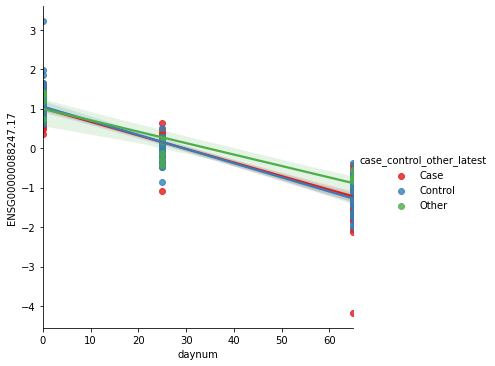

In [23]:
sns.lmplot(x='daynum', y='ENSG00000088247.17', hue='case_control_other_latest', 
           data=data_df, palette='Set1')

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='daynum', ylabel='lnc_ZFP2_3'>

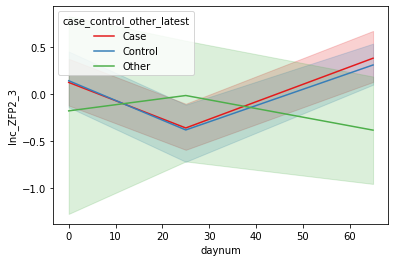

In [24]:
sns.lineplot(x='daynum', y='lnc_ZFP2_3', hue='case_control_other_latest', 
           data=data_df, palette='Set1')

### now re-run everything including age and sex in the mixed model by subject

#### run the model with extra covariates

In [14]:
# extra covariates are 'age_at_baseline', 'sex', some are null remove those rows
data_df = data_df.loc[(~data_df['age_at_baseline'].isna()) & (~data_df['sex'].isna())]
print(data_df.shape)

(286, 32209)


In [15]:
%%time
indep_var = 'daynum'
grouping = 'sampleid'

fs_list = []
lm_results = []
with concurrent.futures.ProcessPoolExecutor(max_workers=max_threads*2) as ppe:
    for batch_features in features_partioned:
        fs_list.append(ppe.submit(run_mm_batch, batch_features, indep_var, data_df, grouping, True))
for future in concurrent.futures.as_completed(fs_list):
    lm_results.append(future.result())

CPU times: user 23.2 s, sys: 26.5 s, total: 49.8 s
Wall time: 47min 23s


In [16]:
# flatten the list
results = [item for sublist in lm_results for item in sublist]

In [17]:
results_df = pd.DataFrame(data=results, columns=['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
print(results_df.shape)
display(results_df.head())

(32108, 5)


,feature,coef,stderr,term_cnt,p-value
0,ENSG00000266245.1,0.000067,0.002269,5,9.765154e-01
1,lnc_CAPN1_1,0.002550,0.002163,5,2.383926e-01
2,lnc_LAMA1_8,0.014522,0.002060,5,1.807126e-12
3,lnc_TMEM154_2,-0.013009,0.002122,5,8.754014e-10
4,ENSG00000118873.15,0.010224,0.002103,5,1.168539e-06


#### calc FDR

In [18]:
alpha=0.05
method='fdr_bh'
test_adjust = smm.multipletests(np.array(results_df['p-value']),
                                alpha=alpha, method=method)
results_df['bh_fdr'] = test_adjust[1]

print(results_df.loc[results_df['bh_fdr'] < 0.05].shape)
display(results_df.head())

(27864, 6)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,ENSG00000266245.1,0.000067,0.002269,5,9.765154e-01,9.782826e-01
1,lnc_CAPN1_1,0.002550,0.002163,5,2.383926e-01,2.583471e-01
2,lnc_LAMA1_8,0.014522,0.002060,5,1.807126e-12,3.297147e-12
3,lnc_TMEM154_2,-0.013009,0.002122,5,8.754014e-10,1.439338e-09
4,ENSG00000118873.15,0.010224,0.002103,5,1.168539e-06,1.696024e-06


#### save the discovery cohort results

In [21]:
sig_df = results_df.loc[results_df['bh_fdr'] < 0.05]
display(sig_df.loc[sig_df['p-value'] == min(sig_df['p-value'])])
display(sig_df.loc[sig_df['p-value'] == max(sig_df['p-value'])])

,feature,coef,stderr,term_cnt,p-value,bh_fdr
111,ENSG00000088247.17,-0.034746,0.000914,5,0.0,0.0


,feature,coef,stderr,term_cnt,p-value,bh_fdr
6024,LINC00630,0.004537,0.002246,5,0.043347,0.049949


In [20]:
out_file = f'{results_dir}/{cohort}.expr_time_cov_mm.csv'
sig_df.to_csv(out_file, index=False)

#### do some example plotting

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='daynum', ylabel='ENSG00000088247.17'>

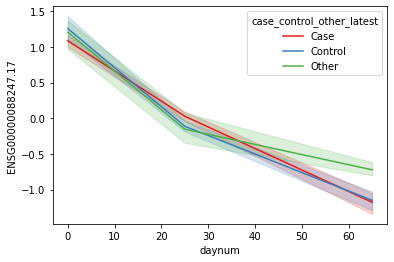

In [24]:
sns.lineplot(x='daynum', y='ENSG00000088247.17', hue='case_control_other_latest', 
           data=data_df, palette='Set1')

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='daynum', ylabel='LINC00630'>

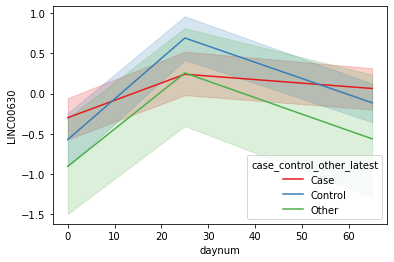

In [23]:
sns.lineplot(x='daynum', y='LINC00630', hue='case_control_other_latest', 
           data=data_df, palette='Set1')

#### check the replicated mixed model results against the mixed model results also adjusted for age and sex

In [30]:
mm_file = f'{results_dir}/{cohort}.expr_time_mm.csv'
mm_cov_file =  f'{results_dir}/{cohort}.expr_time_cov_mm.csv'
mm_results_df = pd.read_csv(mm_file)
mm_results_df = mm_results_df.loc[mm_results_df['bh_fdr'] < 0.05]
print(mm_results_df.shape)
mm_cov_results_df = pd.read_csv(mm_cov_file)
mm_cov_results_df = mm_cov_results_df.loc[mm_cov_results_df['bh_fdr'] < 0.05]
print(mm_cov_results_df.shape)

(27878, 6)
(27864, 6)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
in_both = set(mm_results_df['feature']) & set(mm_cov_results_df['feature'])
print(len(in_both))
in_just_mm = set(mm_results_df['feature']) - set(mm_cov_results_df['feature']) 
print(len(in_just_mm))
in_just_mm_cov = set(mm_cov_results_df['feature']) - set(mm_results_df['feature'])
print(len(in_just_mm_cov))

27792
86
72


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
both_file = f'{results_dir}/{cohort}.expr_time_mm_and_mmcov.csv'
just_mm_file = f'{results_dir}/{cohort}.expr_time_mm_only.csv'
just_mmcov_file = f'{results_dir}/{cohort}.expr_time_mmcov_only.csv'

mm_results_df.loc[mm_results_df['feature'].isin(in_both)].to_csv(both_file, index=False)
mm_results_df.loc[mm_results_df['feature'].isin(in_just_mm)].to_csv(just_mm_file, index=False)
mm_cov_results_df.loc[mm_cov_results_df['feature'].isin(in_just_mm_cov)].to_csv(just_mmcov_file, index=False)

In [33]:
mm_results_df.head()

,feature,coef,stderr,term_cnt,p-value,bh_fdr
0,ENSG00000169499.14,0.030004,0.001338,3,2.623264e-111,5.049625e-110
1,PCF11_AS1,-0.018897,0.001842,3,1.051302e-24,2.829912e-24
2,ENSG00000185164.14,0.024467,0.001457,3,2.721126e-63,1.901413e-62
3,lnc_DHX57_6,-0.011693,0.002093,3,2.304500e-08,3.582150e-08
4,ENSG00000102362.15,0.029432,0.001354,3,8.609702e-105,1.442799e-103


In [34]:
mm_cov_results_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,coef,stderr,term_cnt,p-value,bh_fdr
2,lnc_LAMA1_8,0.014522,0.002060,5,1.807126e-12,3.297147e-12
3,lnc_TMEM154_2,-0.013009,0.002122,5,8.754014e-10,1.439338e-09
4,ENSG00000118873.15,0.010224,0.002103,5,1.168539e-06,1.696024e-06
5,lnc_ZNF568_4,0.007300,0.002189,5,8.533429e-04,1.088477e-03
6,lnc_NAGK_2,0.022303,0.001656,5,2.324264e-41,9.828455e-41


In [35]:
both_df = mm_results_df.merge(mm_cov_results_df, how='inner', left_on='feature', right_on='feature')
print(both_df.shape)

(27792, 11)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
results_df['log10_pvalue'] = np.log10(results_df['p-value'])*-1
results_df['t_score'] = results_df['coef']/results_df['stderr']

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='coef_x', ylabel='coef_y'>

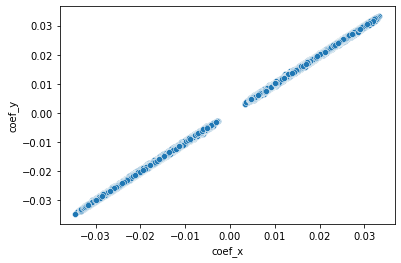

In [38]:
sns.scatterplot(x='coef_x', y='coef_y', data=both_df)